None


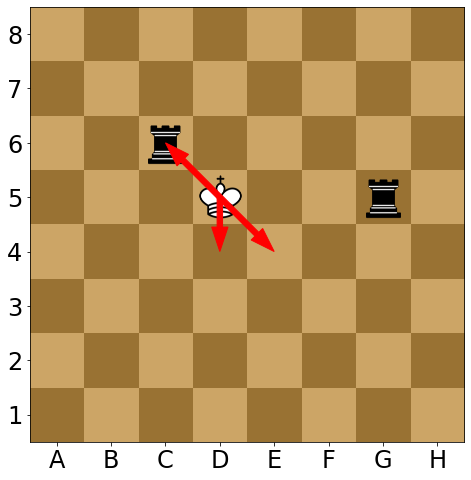

In [2]:
from ChessCore import *

game = ChessGame('8/8/2r5/3K2r1/8/8/8/8 w - - 0 1')
moves = game.generate_all_moves()
game.plot(moves=moves)